In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [21]:
# Step 1: Load the combined data from 'data/combined_df.csv' and explore the dataset
import pandas as pd

# Load the data
data = pd.read_csv('data/combined_df.csv')

# Display the first few rows of the dataset
data.sample(10)

,id,datetime,title,text,score,upvote_ratio,url,subreddit,has_text,title_len,text_len
116,1dxymx4,2024-07-08 03:12:25,"One month doing options, might kms",Any advice for a comeback would be awesome.,16,0.60,https://i.redd.it/cjy8hemap7bd1.jpeg,1,True,6,9
3298,1disy19,2024-06-18 15:07:03,VoteDoge Debate Video Teaser 2: The Second Cli...,We’re thrilled to share the second teaser from...,12,1.00,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,10,225
3274,1djqjrx,2024-06-19 18:39:12,Revolutionary RWA & NFT Technology | Lets Join...,Welcome to $UPLOAD ! \n\n\nUpload3D is the wor...,0,0.50,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,11,210
2341,l9mo6a,2021-01-31 21:36:42,The moon has been reached. Next stop: MARS! 🚀🚀...,notexthere,51694,0.96,https://v.redd.it/x961o3qglqe61,1,False,13,1
963,1cg10zp,2024-04-29 14:50:07,DJT to $60-$70,"As insane as it is, DJT's on its way back up t...",26,0.56,https://www.reddit.com/r/wallstreetbets/commen...,1,True,3,48
5511,b6yh8d,2019-03-29 15:12:38,"Parent company clients: Amazon, Google, Facebo...","Hi guys, I'm back again! This time with anothe...",1,0.55,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,10,1016
687,1dpyevb,2024-06-27 18:29:18,VALE @bottom ?,I have been in and out of VALE for years. Mine...,10,0.81,https://www.reddit.com/r/wallstreetbets/commen...,1,True,3,70
2297,laay7m,2021-02-01 18:58:08,"digital billboard in johnson city, TN. retards...",notexthere,68725,0.97,https://i.redd.it/12ch27p7ywe61.jpg,1,False,9,1
5124,l8fxms,2021-01-30 06:42:34,r/ethtrader Donuts 🍩,"It's jumped 1000% in 24 hours, low mcap 4m and...",3,0.62,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,3,88
4522,oz647n,2021-08-06 12:58:07,$ROBO | Launch on PSC in 5 hours | Presale end...,\n\n***Welcome To RoboToken ($ROBO)***\n\nPr...,2491,0.99,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,40,177


In [22]:
# Explore the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5545 entries, 0 to 5544
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5545 non-null   object 
 1   datetime      5545 non-null   object 
 2   title         5545 non-null   object 
 3   text          5544 non-null   object 
 4   score         5545 non-null   int64  
 5   upvote_ratio  5545 non-null   float64
 6   url           5545 non-null   object 
 7   subreddit     5545 non-null   int64  
 8   has_text      5545 non-null   bool   
 9   title_len     5545 non-null   int64  
 10  text_len      5545 non-null   int64  
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 438.7+ KB


In [23]:
data['subreddit'].value_counts(normalize=True)  # Check the distribution of subreddits

subreddit
1    0.509107
0    0.490893
Name: proportion, dtype: float64

In [24]:
data['subreddit'].value_counts(normalize=True)  # Check the distribution of subreddits

subreddit
1    0.509107
0    0.490893
Name: proportion, dtype: float64

The imbalance is not too bad, around 1.8% more posts in r/wallstreetbets

In [25]:
# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [26]:
# Preprocess the 'title' feature
def preprocess_title(title):
    # Tokenize the title
    tokens = word_tokenize(title.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Calculate sentiment scores
    sentiment_scores = sid.polarity_scores(title)
    
    # Return the processed title and sentiment scores
    return ' '.join(tokens), sentiment_scores['compound']

In [28]:
import nltk
nltk.download('wordnet')
# Apply the preprocessing function to the 'title' feature
data['processed_title'], data['sentiment_score'] = zip(*data['title'].apply(preprocess_title))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/3d093b86-080b-4136-bfe2-
[nltk_data]     e36267327b87/nltk_data...


In [29]:
data

,id,datetime,title,text,score,upvote_ratio,url,subreddit,has_text,title_len,text_len,processed_title,sentiment_score
0,1dzdf1j,2024-07-09 21:00:53,$Sofi is coming back .,I suggest you buy and hold .,3,0.71,https://i.redd.it/ffwh4k2u4kbd1.jpeg,1,True,5,7,$ sofi coming back .,0.0000
1,1dzdebj,2024-07-09 21:00:11,What’s going on with BABA?,The stock has performed really poorly over the...,2,0.67,https://www.reddit.com/r/wallstreetbets/commen...,1,True,6,84,’ going baba ?,0.0000
2,1dzd0u6,2024-07-09 20:44:37,ZI Yolo better late than early,DD was some guy posted about seeing a high vol...,2,0.75,https://i.redd.it/a2n775jx1kbd1.jpeg,1,True,7,14,zi yolo better late early,0.6124
3,1dzckvv,2024-07-09 20:26:14,We are already in a recession,notexthere,3,0.57,https://i.redd.it/1uao7vklyjbd1.png,1,False,6,1,already recession,-0.4215
4,1dzcjix,2024-07-09 20:24:41,🍔McDonalds🍔: At ATL in 52 weeks. How to make y...,"Hello gentleman. \n\nFirst of all, the only DD...",1,0.55,https://www.reddit.com/r/wallstreetbets/commen...,1,True,16,138,🍔mcdonalds🍔 : atl 52 week . make easiest profi...,0.6908
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,81imud,2018-03-02 21:41:43,Whats the deal with this moon baby?,I still cant find anyone talking about it.\n\n...,0,0.50,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,7,198,whats deal moon baby ?,0.0000
5541,7vqu3h,2018-02-06 21:34:59,Aigang - Way Undervalued at its $9mil market c...,notexthere,5,0.57,https://medium.com/aigang-network/aigang-dev-u...,0,False,21,1,aigang - way undervalued $ 9mil market cap . g...,0.7906
5542,7urukk,2018-02-02 15:01:36,ELTCOIN Is Only 3 Cents.. Could This Crypto Cu...,notexthere,0,0.50,http://blogforbitcoin.com/eltcoin-is-only-3-ce...,0,False,11,1,eltcoin 3 cent .. could crypto currency go 100x ?,0.0000
5543,7untqv,2018-02-02 01:33:52,"PACCoin, reborn. Read em and weep.",notexthere,6,0.63,http://download.paccoin.net/PAC_White_Paper_20...,0,False,6,1,"paccoin , reborn . read em weep .",-0.5719


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5545 entries, 0 to 5544
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5545 non-null   object 
 1   datetime         5545 non-null   object 
 2   title            5545 non-null   object 
 3   text             5544 non-null   object 
 4   score            5545 non-null   int64  
 5   upvote_ratio     5545 non-null   float64
 6   url              5545 non-null   object 
 7   subreddit        5545 non-null   int64  
 8   has_text         5545 non-null   bool   
 9   title_len        5545 non-null   int64  
 10  text_len         5545 non-null   int64  
 11  processed_title  5545 non-null   object 
 12  sentiment_score  5545 non-null   float64
dtypes: bool(1), float64(2), int64(4), object(6)
memory usage: 525.4+ KB


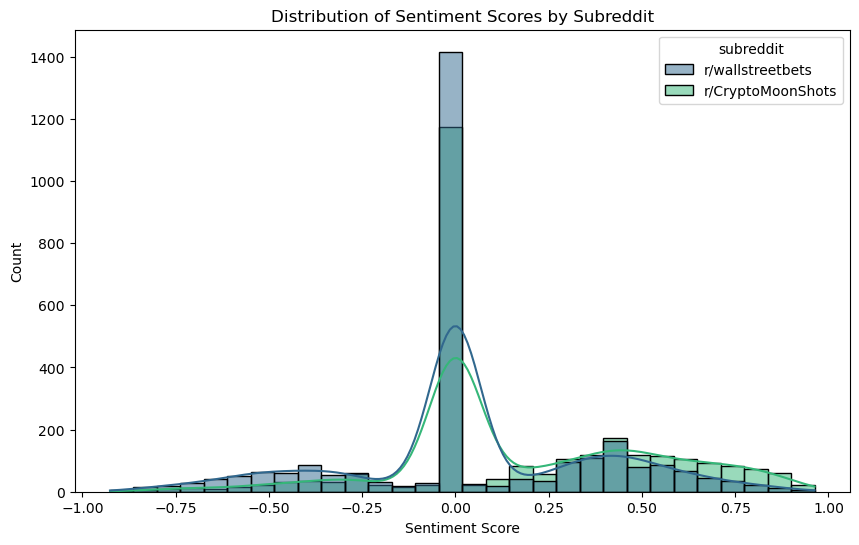

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with sentiment scores and subreddit mapping
sentiment_df = pd.DataFrame({'sentiment_score': data['sentiment_score'], 'subreddit': data['subreddit']})

# Map subreddit values to their respective names
sentiment_df['subreddit'] = sentiment_df['subreddit'].map({1: 'r/wallstreetbets', 0: 'r/CryptoMoonShots'})

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data=sentiment_df, x='sentiment_score', hue='subreddit', kde=True, bins=30, palette='viridis')
plt.title('Distribution of Sentiment Scores by Subreddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

Baseline

In [34]:
X = data['processed_title']
y = data['subreddit']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
baseline = (y_test == y_train.mode()[0]).mean()

In [37]:
baseline

0.5193868349864743

In [42]:
# Define the pipeline for Logistic Regression with CountVectorizer
logreg_pipe_cv = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])


In [43]:
# Define the parameter grid for grid search
logreg_param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2,3)],  # unigrams or bigrams or trigrams
    'vectorizer__max_df': [0.5, 0.75, 1.0],  # maximum document frequency
    'classifier__C': [0.1, 1, 10]  # regularization parameter
}

In [44]:
# Perform grid search
logreg_grid_cv = GridSearchCV(logreg_pipe_cv, logreg_param_grid, cv=5)
logreg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'vectorizer__max_df': [0.5, 0.75, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 3)]})

In [45]:
# Print the best parameters and the accuracy score
print("Best parameters for Logistic Regression with CountVectorizer:", logreg_grid_cv.best_params_)
print("Training Accuracy score for Logistic Regression with CountVectorizer:", logreg_grid_cv.best_score_)

Best parameters for Logistic Regression with CountVectorizer: {'classifier__C': 10, 'vectorizer__max_df': 0.5, 'vectorizer__ngram_range': (1, 1)}
Training Accuracy score for Logistic Regression with CountVectorizer: 0.9283141371360086


In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test data
y_pred = logreg_grid_cv.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.9269612263300271


In [91]:
# Generate and print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       533
           1       0.89      0.98      0.93       576

    accuracy                           0.93      1109
   macro avg       0.93      0.92      0.93      1109
weighted avg       0.93      0.93      0.93      1109



#### Logistic Regression:
- Precision: The model has a high precision fohCryptoMoonshotss around 0.97,, indicating that when it predictsthata subreddit, it is correct the majority of the time However, the precision for r/wallstreetbets is not as high, below .90, at 0.89.
- Recall: The model has high recall f r/wallstreetbetsts, indicating that it can effectively identify the majority of the posts fothech subreddit.
- F1-score: The F1-score balances precision and recall, and it is high for both subreddits, indicating a good overall performance.
- Accuracy: The model has an accuracy of 93%, indicating the proportion of correctly classified samples.

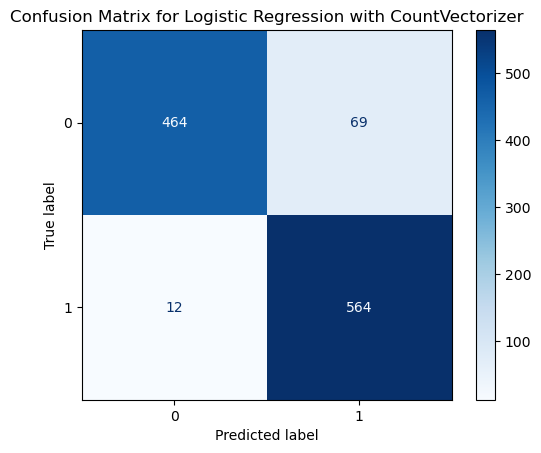

In [48]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=logreg_grid_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_grid_cv.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression with CountVectorizer')
plt.show()

In [50]:
# Define the pipeline for Multinomial Naive Bayes with TfidfVectorizer
nb_pipe_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

In [51]:
# Define the parameter grid for grid search
nb_param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'vectorizer__max_df': [0.5, 0.75, 1.0],  # maximum document frequency
    'classifier__alpha': [0.1, 1, 10]  # additive (Laplace/Lidstone) smoothing parameter
}

In [52]:
# Perform grid search
nb_grid_tfidf = GridSearchCV(nb_pipe_tfidf, nb_param_grid, cv=5)
nb_grid_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.1, 1, 10],
                         'vectorizer__max_df': [0.5, 0.75, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]})

In [53]:
# Print the best parameters and the accuracy score
print("Best parameters for Multinomial Naive Bayes with TfidfVectorizer:", nb_grid_tfidf.best_params_)
print("Accuracy score for Multinomial Naive Bayes with TfidfVectorizer:", nb_grid_tfidf.best_score_)

Best parameters for Multinomial Naive Bayes with TfidfVectorizer: {'classifier__alpha': 1, 'vectorizer__max_df': 0.5, 'vectorizer__ngram_range': (1, 1)}
Accuracy score for Multinomial Naive Bayes with TfidfVectorizer: 0.927862671013742


In [54]:
# Make predictions on the test data
y_pred_nb = nb_grid_tfidf.predict(X_test)

In [55]:
# Calculate accuracy score
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy Score for Multinomial Naive Bayes:", accuracy_nb)

Accuracy Score for Multinomial Naive Bayes: 0.9287646528403968


In [56]:
# Generate and print the classification report
print("Classification Report for Multinomial Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

Classification Report for Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       533
           1       0.92      0.94      0.93       576

    accuracy                           0.93      1109
   macro avg       0.93      0.93      0.93      1109
weighted avg       0.93      0.93      0.93      1109



#### Multinomial Naive Bayes:- Precision, Recall: Improvement in lower bounds, bringing it above .90, but sacrifices some precision and recall in the respective higher bounds, dropping from .98 to .94. Still quite robust. 
-  F1-score, and Accuracy: The metrics for Multinomial Naive Bayes are similar to those of Logistic Regression, indicating  robust,  overall performance.
-  Might be the best balanced model..

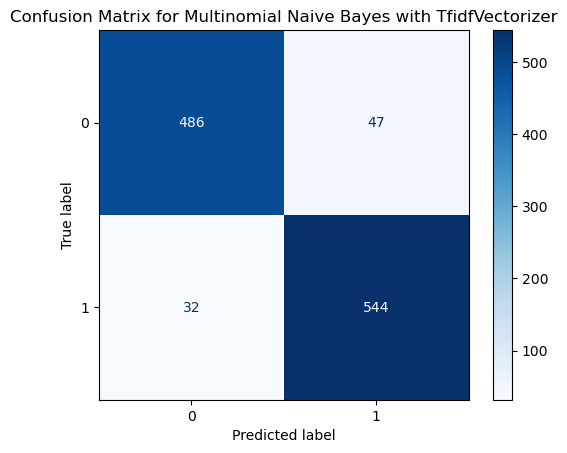

In [57]:
# Generate and plot the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=nb_grid_tfidf.classes_)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_grid_tfidf.classes_)
disp_nb.plot(cmap='Blues')
plt.title('Confusion Matrix for Multinomial Naive Bayes with TfidfVectorizer')
plt.show()

In [58]:
# Define the pipeline for Random Forest Classifier with CountVectorizer
rf_pipe_cv = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier())
])

In [59]:
# Define the parameter grid for grid search
rf_param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'vectorizer__max_df': [0.5, 0.75, 1.0],  # maximum document frequency
    'classifier__n_estimators': [100, 200, 300],  # number of trees in the forest
    'classifier__max_depth': [10, 20, 30]  # maximum depth of the tree
}

In [60]:
# Perform grid search
rf_grid_cv = GridSearchCV(rf_pipe_cv, rf_param_grid, cv=5)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__n_estimators': [100, 200, 300],
                         'vectorizer__max_df': [0.5, 0.75, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]})

In [61]:
# Print the best parameters and the accuracy score
print("Best parameters for Random Forest Classifier with CountVectorizer:", rf_grid_cv.best_params_)
print("Accuracy score for Random Forest Classifier with CountVectorizer:", rf_grid_cv.best_score_)

Best parameters for Random Forest Classifier with CountVectorizer: {'classifier__max_depth': 30, 'classifier__n_estimators': 300, 'vectorizer__max_df': 0.75, 'vectorizer__ngram_range': (1, 1)}
Accuracy score for Random Forest Classifier with CountVectorizer: 0.8908912012350569


In [62]:
# Make predictions on the test data
y_pred_rf = rf_grid_cv.predict(X_test)

In [63]:
# Calculate accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Score for Random Forest Classifier:", accuracy_rf)

Accuracy Score for Random Forest Classifier: 0.8782687105500451


In [64]:
# Generate and print the classification report
print("Classification Report for Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       533
           1       0.82      0.99      0.89       576

    accuracy                           0.88      1109
   macro avg       0.90      0.87      0.88      1109
weighted avg       0.90      0.88      0.88      1109



#### Random Forest Classifier:
- Precision: The precision for subreddit 0 is high, but for subreddit 1, it is lower.
- Recall: The recall for subreddit 1 is high, but for subreddit 0, it is much lower.
- F1-score: The F1-score for both subreddits is slightly lower compared to the other models.
- Accuracy: The accuracy is 88%, which is lower than the other models. Let's ignore this one as a viable model.

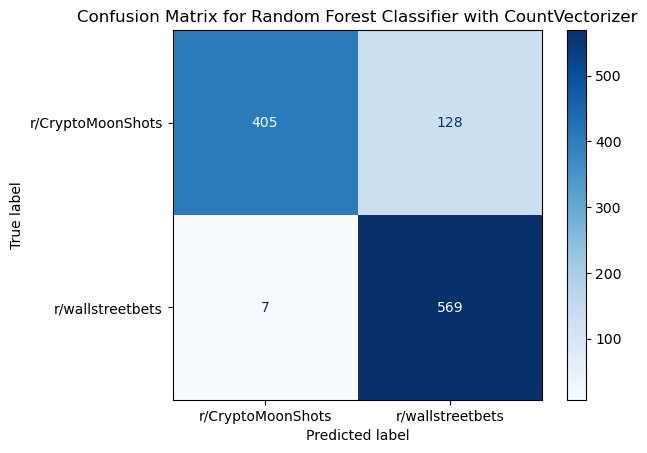

In [76]:
# Generate and plot the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_grid_cv.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['r/CryptoMoonShots', 'r/wallstreetbets'])
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier with CountVectorizer')
plt.show()

In [77]:
from scipy.stats import mode

# Combine predictions from the three models
ensemble_pred = np.array([y_pred, y_pred_nb])
final_pred = mode(ensemble_pred)[0]

In [78]:
y_test

3424    0
1616    1
5231    0
230     1
2042    1
       ..
3956    0
1321    1
1322    1
3619    0
70      1
Name: subreddit, Length: 1109, dtype: int64

In [79]:
final_pred

array([0, 1, 1, ..., 1, 1, 1])

In [80]:
# Calculate accuracy score for the ensembled model
accuracy_ensemble = accuracy_score(y_test, final_pred)
print("Accuracy Score for the Ensembled Model:", accuracy_ensemble)

Accuracy Score for the Ensembled Model: 0.9314697926059513


In [87]:
# Generate and print the classification report
print("Classification Report for Ensembled Model:")
print(classification_report(y_test, final_pred))

Classification Report for Ensembled Model:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       533
           1       0.93      0.94      0.93       576

    accuracy                           0.93      1109
   macro avg       0.93      0.93      0.93      1109
weighted avg       0.93      0.93      0.93      1109




#### Ensembled Model:
- Precision, Recall, F1-score, and Accuracy: The ensembled model has similar performance to the first two individual models, with high precision of 0.93, recall of around 0.93, F1-score of 0.93, and accuracy of 0.93 for both subreddits.
- This will give more of a balance with the false negatives and positives. Let's choose this model for production!

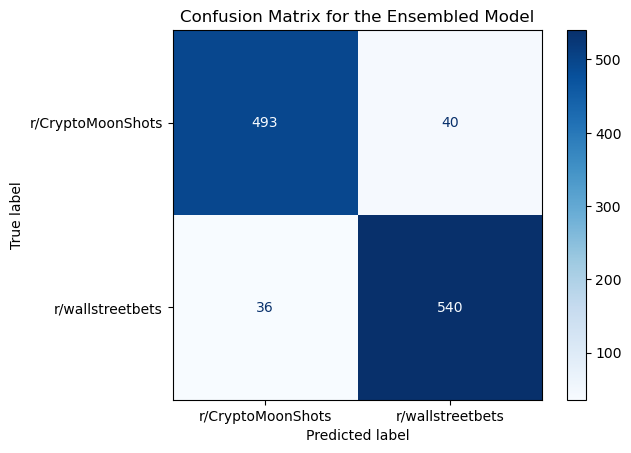

In [82]:
# Generate and plot the confusion matrix for the ensembled model
cm_ensemble = confusion_matrix(y_test, final_pred, labels=[0, 1])
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['r/CryptoMoonShots', 'r/wallstreetbets'])
disp_ensemble.plot(cmap='Blues')
plt.title('Confusion Matrix for the Ensembled Model')
plt.show()

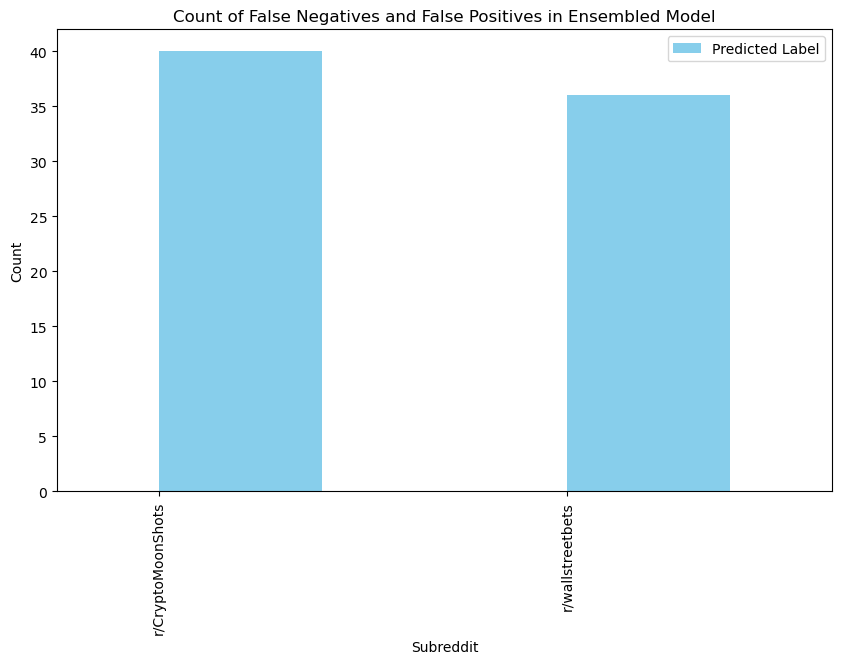

In [88]:
# Identify the incorrect predictions for the ensembled model
incorrect_predictions = np.where(final_pred != y_test)[0]

# Create a new DataFrame to store the incorrect predictions
incorrect_df = X_test.reset_index(drop=True)[incorrect_predictions].to_frame()
incorrect_df['true_label'] = y_test.reset_index(drop=True)[incorrect_predictions]
incorrect_df['predicted_label'] = final_pred[incorrect_predictions]

# Plot the count of false negatives and false positives
plt.figure(figsize=(10, 6))
# incorrect_df['true_label'].value_counts().plot(kind='bar', color='lightcoral', width=0.4, position=1, label='True Label')
incorrect_df['predicted_label'].value_counts().plot(kind='bar', color='skyblue', width=0.4, position=0, label='Predicted Label')
plt.title('Count of False Negatives and False Positives in Ensembled Model')
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['r/CryptoMoonShots', 'r/wallstreetbets'])
plt.legend()
plt.show()